# Tutorial 5: Introducción a Redes Neuronales Recurrentes.

##### <strong>RNN y PyTorch </strong>

### Cuerpo Docente

- Profesores: [Andrés Abeliuk](https://aabeliuk.github.io/), [Fabián Villena](https://villena.cl/).
- Profesor Auxiliar: Martín Paredes


### Objetivos del Tutorial

- Entender que son las Redes Neuronales Recurrentes.
- Revisar una librería de Deep Learning, `PyTorch`.
- Entender el flujo de pasos para programar una Red Neuronal en `PyTorch`.
- Programar una RNN simple para un problema de clasificación.


In [1]:
!pip uninstall -y torch torchvision torchaudio

!pip install torch==2.3.0 --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torch 2.3.0+cu121
Uninstalling torch-2.3.0+cu121:
  Successfully uninstalled torch-2.3.0+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.3.0%2Bcu121-cp312-cp312-linux_x86_64.whl (780.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
timm 1.0.22 requires torchvision, which is not installed.
fastai 2.8.5 requires torchvision>=0.11, which is not installed.


In [2]:
!pip uninstall -y scipy
!pip install scipy==1.11.4

Found existing installation: scipy 1.11.4
Uninstalling scipy-1.11.4:
  Successfully uninstalled scipy-1.11.4
  Using cached scipy-1.11.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.11.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.5 requires torchvision>=0.11, which is not installed.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires scipy>=1.13, but you have scipy 1.11.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.

In [3]:
!pip install torchtext

In [4]:
!pip install scikit-plot

In [5]:
import csv
import pandas as pd
from google.colab import files

import torch
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

from torch import nn
from torch.nn import functional as F

from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

from torch.optim import Adam

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np


/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

## Redes Neuronales Recurrentes para Clasificación de texto

Los tipos de redes neuronales como las redes fully connected  o las convolucionales son buenas para identificar patrones en los datos, pero no tienen memoria. Tratan cada ejemplo de datos y partes del ejemplo como independientes entre sí. No pueden mantener ningún estado/memoria sobre ejemplos previamente vistos. Este tipo de comportamiento es bueno siempre y cuando cada ejemplo, como las imágenes, sea independiente de los demás. Pero hay situaciones en las que recordar información de estado sobre ejemplos previamente vistos puede ayudar a obtener mejores resultados. Digamos, por ejemplo, en la tarea de procesamiento de lenguaje natural de generación de texto, si nuestra red puede recordar alguna información de estado sobre las palabras vistas, entonces puede ayudar a recordar el estado y generar nuevas palabras mejores ya que ahora conoce el contexto de la oración. Este tipo de enfoque también puede ayudar con datos de series temporales, donde la nueva predicción generalmente depende de los últimos ejemplos de texto.

Para resolver el problema de mantener la memoria, se introdujeron las redes neuronales recurrentes (RNN). Las redes neuronales recurrentes mantienen el estado de los ejemplos de datos y lo utilizan para mejorar los resultados. Si el lector está interesado en aprender sobre el funcionamiento interno de las RNN, recomendamos este blog que lo cubre en detalle.

Como parte de este tutorial, vamos a diseñar RNNs simples usando PyTorch para resolver tareas de clasificación de texto. Probaremos diferentes enfoques para usar RNNs en la clasificación de documentos de texto. Utilizaremos el enfoque de incrustación de palabras para vectorizar palabras en vectores de valores reales antes de proporcionárselos a las RNNs. El objetivo principal del tutorial es iniciar a las personas en el uso de RNNs para tareas de clasificación de texto.

<img src="https://ashutoshtripathicom.files.wordpress.com/2021/06/rnn-vs-lstm.png">

<center>Arquitectura de una Red Recurrente y una LSTM.</center>





### Cargar el dataset

En esta sección, hemos cargaremos el conjunto de datos `AG_NEWS` para crear un vocabulario utilizando tokens generados a partir de ejemplos de texto del conjunto de datos. Posteriormente, el vocabulario se utilizará para mapear tokens a índices que se utilizarán para identificarlos. Estos índices generados para tokens de ejemplos de texto se darán como entrada a las redes neuronales para clasificar documentos de texto.

Para esto debemos cargar los archivos de entrenamientos y testing:

In [6]:
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/tutoriales/data/ag_news/train.csv
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/tutoriales/data/ag_news/test.csv

--2025-11-18 19:48:37--  https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/tutoriales/data/ag_news/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28946992 (28M) [text/plain]
Saving to: ‘train.csv.2’

train.csv.2         100%[===================>]  27.61M  --.-KB/s    in 0.1s    

2025-11-18 19:48:38 (202 MB/s) - ‘train.csv.2’ saved [28946992/28946992]

--2025-11-18 19:48:38--  https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/tutoriales/data/ag_news/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


El `AG_NEWS` dataset, es un conjunto de datos que clasifica diferentes artículos de noticias de acuerdos a su contenidos, por lo que presenta la siguientes columnas:

- El índice de la clase a la pertence el artículo.
- El título del artículo.
- La Descripción del artículo

En el siguiente [link](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) es posible encontrar más información del dataset.

In [7]:
train_df = pd.read_csv('train.csv')
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Para que `PyTorch` sea capaz tomar la información del dataset, es necesario cargarlo a través de un generador, para eso creamos la siguiente función que extrae la etiqueta y el contenido de la noticias.

In [8]:
def load_dataset(dataset):
  with open(dataset, encoding='utf-8') as dataset_file:
    reader = csv.reader(dataset_file)
    next(reader)
    for row in reader:
      yield int(row[0]), f'{row[1]} {row[2]}'

In [9]:
next(load_dataset('test.csv'))

(3,
 "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.")

Luego, ejecutamos la función tanto los datasets de `train` y `test`:

In [10]:
train_dataset = load_dataset('train.csv')
test_dataset = load_dataset('test.csv')

### Crear vocabulario

Una vez que hemos cargado el dataset, es necesario crear nuestro vocabulario a partir de los tokens que componen nuestro dataset. Para esto, se deben seguir los siguientes pasos:

- Es necesario tokenizar el dataset.
- A partir del el dataset tokenizado, se crea el vocabulario.

Para crear el vocabulario usaremos la API de `torchtext`, una librería de `PyTorch`, que contiene una API para trabajar usando métodos de deep learning para NLP.

In [11]:
tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_dataset, test_dataset]), min_freq=1, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])

Internamente, la estructura del vocabulario, le asigna un índice a token dentro del vocaluario. Como se ve en el siguiente anterior. Con esto es posible obtener todos los indice de una oración dentro del corpus de texto.

In [12]:
tokens = tokenizer("Hello how are you?, Welcome to CoderzColumn!!")
indexes = vocab(tokens)

tokens, indexes

(['hello',
  'how',
  'are',
  'you',
  '?',
  ',',
  'welcome',
  'to',
  'coderzcolumn',
  '!',
  '!'],
 [12388, 355, 42, 164, 80, 3, 3298, 4, 0, 747, 747])

### Cargar el `dataloader`.

Para crear el dataloader, debemos cargar los datos a una instancia de la clase `Dataset` de `PyTorch`, sin embargo podemos usar la función `to_map_style_dataset` para no implementar la clase completa. Ojo que el uso de la función depende caso, a veces es inevitable tener que implementar su propio wrapper.

In [13]:
train_dataset = load_dataset('train.csv')
test_dataset = load_dataset('test.csv')
train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

max_words = 25


Dado que iremos transformando el dataset a medida que extrayendo cada `batch` de texto, es necesario definir una función que haga esta conversión.

In [14]:
def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.

    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1 ## We have deducted 1 from target names to get them in range [0,1,2,3] from [1,2,3,4]

Luego, definimos nuestra instancia del `DataLoader`, este objeto será aquel que irá iterando y extrayendo cada `batch` del dataset.

In [15]:
train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

### Definición Red Neuronal Recurrente

Previamente, a la definición de la Red Neuronal debemos definir los hiperparametros de está. No es una obligación, pero siempre es bueno hacerlo antes, para entender las dimensiones de nuestra red.

In [16]:

embed_len = 50
hidden_dim = 50
n_layers=1

Para definir una Red Neuronal en `PyTorch`, debemos extender la clase `torch.Module`, en este caso `torch` fue renombrado como `nn`. Dentro de la constructor de la clase se definen todas las capas de la que nuestra red neuronal, en el caso de la tarea que buscamos resolver, se definen las siguientes:

- Una capa de `Embedding`, para encodar cada una de las palabras del vocabulario a un vector denso.
- Una capa de `RNN`, que implementa la arquitectura de `RNN`, por lo que no es necesario hacerlo a mano. Esta red agrega la secuencia de temporalidad de cada de las de palabras, considerando el contexto de la frase.
- Una capa `Linear`, esta capa se encarga de resolver la tarea de clasificación que buscamos.

In [17]:
class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim))
        return self.linear(output[:,-1])

Definimos el clasificador.

In [18]:
rnn_classifier = RNNClassifier()

rnn_classifier

RNNClassifier(
  (embedding_layer): Embedding(98628, 50)
  (rnn): RNN(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

Para explorar las dimensiones de nuestras capas, podemos ejecutar:

In [19]:
for layer in rnn_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(98628, 50)
Parameters : 
torch.Size([98628, 50])

Layer : RNN(50, 50, batch_first=True)
Parameters : 
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])

Layer : Linear(in_features=50, out_features=4, bias=True)
Parameters : 
torch.Size([4, 50])
torch.Size([4])



### Funciones de entrenamiento y Evaluación

Para extraer los valores de accuracy es necesario calcularlos a medida que se entrena el `batch`, para esto definimos una función que se encarga de entrenar en los modelo en cada iteración, guardando la loss y el accuracy en listas estandar de Python, para esto se implementan dos funciones:

- `CalValLossAndAccuracy`: calcula la loss de la función de pérdida y guarda el accuracy que servirá para evaluar el modelo.
- `TrainModel`: gestiona el entrenamiento del modelo en base a la cantidad de épocas escogidas por el usuario.

In [20]:


def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

### Entrenamiento del modelo.

Ejecutamos el entramiento del modelo, esto tardará algunos minutos:

In [21]:


epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

TrainModel(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:16<00:00,  7.28it/s]


Train Loss : 1.321
Valid Loss : 1.134
Valid Acc  : 0.510


100%|██████████| 118/118 [00:15<00:00,  7.83it/s]


Train Loss : 0.923
Valid Loss : 0.777
Valid Acc  : 0.704


100%|██████████| 118/118 [00:15<00:00,  7.39it/s]


Train Loss : 0.664
Valid Loss : 0.617
Valid Acc  : 0.774


100%|██████████| 118/118 [00:15<00:00,  7.83it/s]


Train Loss : 0.540
Valid Loss : 0.546
Valid Acc  : 0.806


100%|██████████| 118/118 [00:15<00:00,  7.85it/s]


Train Loss : 0.465
Valid Loss : 0.504
Valid Acc  : 0.824


100%|██████████| 118/118 [00:15<00:00,  7.61it/s]


Train Loss : 0.415
Valid Loss : 0.468
Valid Acc  : 0.837


100%|██████████| 118/118 [00:15<00:00,  7.53it/s]


Train Loss : 0.376
Valid Loss : 0.458
Valid Acc  : 0.843


100%|██████████| 118/118 [00:15<00:00,  7.83it/s]


Train Loss : 0.345
Valid Loss : 0.437
Valid Acc  : 0.849


100%|██████████| 118/118 [00:14<00:00,  7.90it/s]


Train Loss : 0.321
Valid Loss : 0.424
Valid Acc  : 0.855


100%|██████████| 118/118 [00:15<00:00,  7.54it/s]


Train Loss : 0.298
Valid Loss : 0.415
Valid Acc  : 0.861


100%|██████████| 118/118 [00:14<00:00,  7.93it/s]


Train Loss : 0.278
Valid Loss : 0.410
Valid Acc  : 0.862


100%|██████████| 118/118 [00:15<00:00,  7.84it/s]


Train Loss : 0.264
Valid Loss : 0.410
Valid Acc  : 0.867


100%|██████████| 118/118 [00:14<00:00,  8.02it/s]


Train Loss : 0.250
Valid Loss : 0.400
Valid Acc  : 0.869


100%|██████████| 118/118 [00:15<00:00,  7.49it/s]


Train Loss : 0.235
Valid Loss : 0.398
Valid Acc  : 0.870


100%|██████████| 118/118 [00:15<00:00,  7.84it/s]


Train Loss : 0.223
Valid Loss : 0.401
Valid Acc  : 0.870


### Realizar prediciones de la Red entrenada.

Para realizar las predicciones del modelo, es necesario evaluar su performance en el conjunto de entrenamiento. Para esto definimos la función `MakePredictions`, que calcula la loss del conjunto de testing y guarda las predicciones en una lista estandar de Python.

In [22]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)

Utlizamos las funciones de `scikit-learn` para generar el reporte de clasificación.

In [23]:


print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8694736842105263

Classification Report : 
              precision    recall  f1-score   support

       World       0.90      0.84      0.87      1900
      Sports       0.93      0.95      0.94      1900
    Business       0.82      0.83      0.83      1900
    Sci/Tech       0.83      0.85      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600


Confusion Matrix : 
[[1603   87  124   86]
 [  28 1808   34   30]
 [  76   27 1576  221]
 [  69   30  180 1621]]


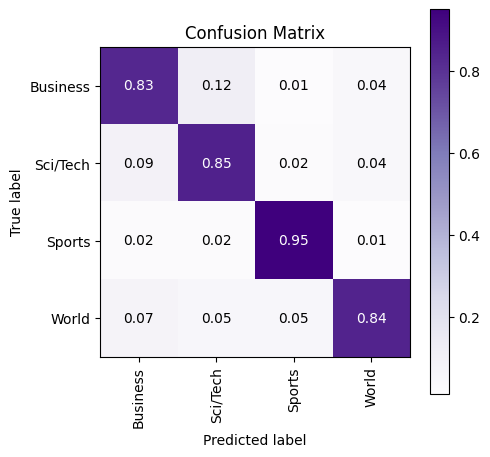

In [24]:

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

### Stackear muchas redes recurrentes.

Este código es similar al anterior, la diferencia es que variamos la cantidad de RNN utilizadas proponiendo una nueva arquitectura que podría mejorar o empeorar la performance del modelo.

In [25]:
embed_len = 50
hidden_dim1 = 50
hidden_dim2 = 60
hidden_dim3 = 75
n_layers=1

class StackingRNNClassifier(nn.Module):
    def __init__(self):
        super(StackingRNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn1 = nn.RNN(input_size=embed_len, hidden_size=hidden_dim1, num_layers=1, batch_first=True)
        self.rnn2 = nn.RNN(input_size=hidden_dim1, hidden_size=hidden_dim2, num_layers=1, batch_first=True)
        self.rnn3 = nn.RNN(input_size=hidden_dim2, hidden_size=hidden_dim3, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim3, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn1(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim1))
        output, hidden = self.rnn2(output, torch.randn(n_layers, len(X_batch), hidden_dim2))
        output, hidden = self.rnn3(output, torch.randn(n_layers, len(X_batch), hidden_dim3))
        return self.linear(output[:,-1])

In [26]:
rnn_classifier = StackingRNNClassifier()

rnn_classifier

StackingRNNClassifier(
  (embedding_layer): Embedding(98628, 50)
  (rnn1): RNN(50, 50, batch_first=True)
  (rnn2): RNN(50, 60, batch_first=True)
  (rnn3): RNN(60, 75, batch_first=True)
  (linear): Linear(in_features=75, out_features=4, bias=True)
)

In [27]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = StackingRNNClassifier()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

TrainModel(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Train Loss : 1.203
Valid Loss : 0.974
Valid Acc  : 0.592


100%|██████████| 118/118 [00:22<00:00,  5.30it/s]


Train Loss : 0.798
Valid Loss : 0.704
Valid Acc  : 0.734


100%|██████████| 118/118 [00:21<00:00,  5.37it/s]


Train Loss : 0.586
Valid Loss : 0.562
Valid Acc  : 0.792


100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


Train Loss : 0.474
Valid Loss : 0.490
Valid Acc  : 0.827


100%|██████████| 118/118 [00:22<00:00,  5.24it/s]


Train Loss : 0.410
Valid Loss : 0.462
Valid Acc  : 0.835


100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Train Loss : 0.366
Valid Loss : 0.434
Valid Acc  : 0.847


100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Train Loss : 0.329
Valid Loss : 0.435
Valid Acc  : 0.845


100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Train Loss : 0.298
Valid Loss : 0.393
Valid Acc  : 0.862


100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Train Loss : 0.273
Valid Loss : 0.382
Valid Acc  : 0.870


100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


Train Loss : 0.254
Valid Loss : 0.377
Valid Acc  : 0.870


100%|██████████| 118/118 [00:22<00:00,  5.36it/s]


Train Loss : 0.233
Valid Loss : 0.381
Valid Acc  : 0.874


100%|██████████| 118/118 [00:22<00:00,  5.28it/s]


Train Loss : 0.218
Valid Loss : 0.374
Valid Acc  : 0.876


100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Train Loss : 0.202
Valid Loss : 0.386
Valid Acc  : 0.874


100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Train Loss : 0.190
Valid Loss : 0.375
Valid Acc  : 0.876


100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Train Loss : 0.179
Valid Loss : 0.392
Valid Acc  : 0.879


In [28]:
Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8769736842105263

Classification Report : 
              precision    recall  f1-score   support

       World       0.88      0.89      0.89      1900
      Sports       0.94      0.93      0.93      1900
    Business       0.84      0.84      0.84      1900
    Sci/Tech       0.84      0.85      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


Confusion Matrix : 
[[1690   41   87   82]
 [  75 1764   32   29]
 [  76   36 1602  186]
 [  69   35  187 1609]]


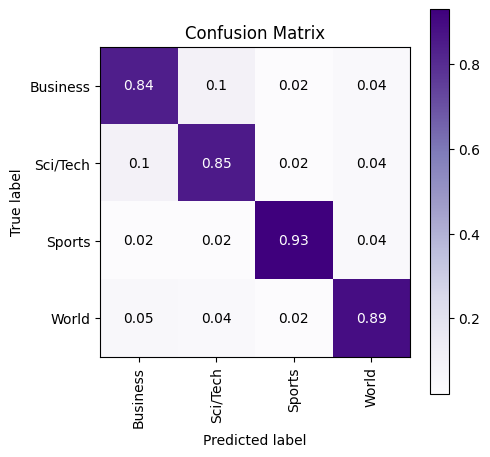

In [29]:
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);